In [1]:
import torch

path = "cora/"
cites = path + "cora.cites"
content = path + "cora.content"

# 索引字典，将原本的论文id转换到从0开始编码
index_dict = dict()
# 标签字典，将字符串标签转化为数值
label_to_index = dict()

features = []
labels = []
edge_index = []

with open(content,"r") as f:
    nodes = f.readlines()
    for node in nodes:
        node_info = node.split()
        index_dict[int(node_info[0])] = len(index_dict)
        features.append([int(i) for i in node_info[1:-1]])
        
        label_str = node_info[-1]
        if(label_str not in label_to_index.keys()):
            label_to_index[label_str] = len(label_to_index)
        labels.append(label_to_index[label_str])

with open(cites,"r") as f:
    edges = f.readlines()
    for edge in edges:
        start, end = edge.split()
        # 训练时将边视为无向的，但原本的边是有向的，因此需要正反添加两次
        edge_index.append([index_dict[int(start)],index_dict[int(end)]])
        edge_index.append([index_dict[int(end)],index_dict[int(start)]])

# 为每个节点增加自环，但后续GCN层默认会添加自环，跳过即可
# for i in range(2708):
#     edge_index.append([i,i])
  
# 转换为Tensor
labels = torch.LongTensor(labels)
features = torch.FloatTensor(features)
# 行归一化
# features = torch.nn.functional.normalize(features, p=1, dim=1)
edge_index =  torch.LongTensor(edge_index)



In [2]:
class GCNNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GCNNet,self).__init__()
        self.GCN1 = GCNConv(num_feature, 16)
        self.GCN2 = GCNConv(16, num_label)  
        self.dropout = torch.nn.Dropout(p=0.5)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GCN1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.GCN2(x, edge_index)
        
        return F.log_softmax(x, dim=1)


In [3]:
class GATNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GATNet,self).__init__()
        self.GAT1 = GATConv(num_feature, 8, heads = 8, concat = True, dropout = 0.3)
#         self.GAT1 = GATConv(num_feature, 8, heads = 8, concat = True, dropout = 0.6)
        self.GAT2 = GATConv(8*8, 4,heads=8, dropout = 0.3)   #8*8是上面的8*头数
        self.GAT3 = GATConv(32,2,heads=2)
        self.GAT4 = GATConv(4,num_label)

        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GAT1(x, edge_index)
# 更改        x = F.relu(x)
        x = F.leaky_relu(x)
        x = self.GAT2(x, edge_index)

        x = F.leaky_relu(x)
        x = self.GAT3(x,edge_index)

        x = F.leaky_relu(x)
        x = self.GAT4(x,edge_index)
        
        return F.log_softmax(x, dim=1)


In [4]:
import numpy as np
# seed = 1234
seed = 5678
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  # Numpy module.
# random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


In [5]:
from torch_geometric.data import Data

In [6]:
mask = torch.randperm(len(index_dict))
train_mask = mask[:140]
val_mask = mask[140:640]
test_mask = mask[640:2708]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cora = Data(x = features, edge_index = edge_index.t().contiguous(), y = labels).to(device)


In [7]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GATConv,SAGEConv
from torch_geometric.datasets import Planetoid

In [8]:
model = GATNet(features.shape[1], len(label_to_index)).to(device)
# model = GCNNet(features.shape[1], len(label_to_index)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    optimizer.zero_grad()
    out = model(cora)
    loss = F.nll_loss(out[train_mask], cora.y[train_mask])
    print('epoch: %d loss: %.4f' %(epoch, loss))
    loss.backward()
    optimizer.step()
    
    if((epoch + 1)% 10 == 0):
        model.eval()
        _, pred = model(cora).max(dim=1)
        correct = int(pred[test_mask].eq(cora.y[test_mask]).sum().item())
        acc = correct / len(test_mask)
        print('Accuracy: {:.4f}'.format(acc))
        model.train()


epoch: 0 loss: 1.9387
epoch: 1 loss: 1.7991
epoch: 2 loss: 1.6934
epoch: 3 loss: 1.5814
epoch: 4 loss: 1.4538
epoch: 5 loss: 1.3855
epoch: 6 loss: 1.3274
epoch: 7 loss: 1.2898
epoch: 8 loss: 1.2619
epoch: 9 loss: 1.2230
Accuracy: 0.3897
epoch: 10 loss: 1.1934
epoch: 11 loss: 1.1716
epoch: 12 loss: 1.1212
epoch: 13 loss: 1.0905
epoch: 14 loss: 1.0749
epoch: 15 loss: 1.0473
epoch: 16 loss: 1.0163
epoch: 17 loss: 1.0103
epoch: 18 loss: 0.9814
epoch: 19 loss: 0.9510
Accuracy: 0.5106
epoch: 20 loss: 0.9355
epoch: 21 loss: 0.9339
epoch: 22 loss: 0.9080
epoch: 23 loss: 0.8856
epoch: 24 loss: 0.8719
epoch: 25 loss: 0.8433
epoch: 26 loss: 0.8144
epoch: 27 loss: 0.7996
epoch: 28 loss: 0.7671
epoch: 29 loss: 0.7458
Accuracy: 0.5798
epoch: 30 loss: 0.7102
epoch: 31 loss: 0.6781
epoch: 32 loss: 0.6533
epoch: 33 loss: 0.6230
epoch: 34 loss: 0.5776
epoch: 35 loss: 0.5621
epoch: 36 loss: 0.5412
epoch: 37 loss: 0.5239
epoch: 38 loss: 0.4922
epoch: 39 loss: 0.4920
Accuracy: 0.6277
epoch: 40 loss: 0.4637

## PR

In [9]:

A  = pred[test_mask].numpy()
type(A)
B = cora.y[test_mask].numpy()

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

print(classification_report(y_true = A,y_pred = B,digits=4))

print(f1_score(y_true=A,y_pred=B, average="micro"))

print(f1_score(y_true=A,y_pred=B,average="macro"))


              precision    recall  f1-score   support

           0     0.8386    0.7593    0.7970       698
           1     0.2555    0.9459    0.4023        37
           2     0.7278    0.6373    0.6796       193
           3     0.6367    0.8879    0.7416       223
           4     0.7547    0.6116    0.6757       327
           5     0.8464    0.8257    0.8359       327
           6     0.6936    0.6198    0.6546       263

    accuracy                         0.7345      2068
   macro avg     0.6790    0.7554    0.6838      2068
weighted avg     0.7656    0.7345    0.7419      2068

0.7345261121856866
0.6838042626857236


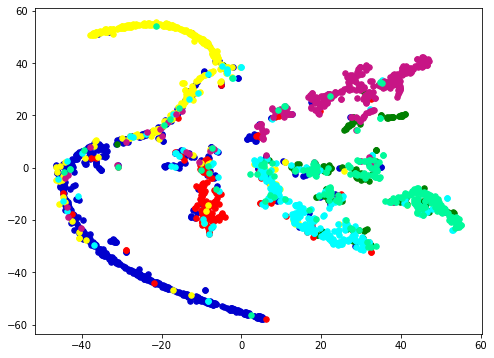

In [10]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

import matplotlib


ts = TSNE(n_components=2)
ts.fit_transform(out[test_mask].to('cpu').detach().numpy())

x = ts.embedding_
y = cora.y[test_mask].to('cpu').detach().numpy()

xi = []
for i in range(7):
    xi.append(x[np.where(y==i)])

colors = ['mediumblue','green','red','yellow','cyan','mediumvioletred','mediumspringgreen']
plt.figure(figsize=(8, 6))
# plt.title('GAT_4_layer')
label =['web攻击','端口1433攻击','木马后门','Myking病毒','正常日志']
s = ['abcde']
for i in range(7):
    plt.scatter(xi[i][:,0],xi[i][:,1],s=30,color=colors[i],marker='o',alpha=1)
# plt.legend(handles=scatter.legend_elements()[0], labels=label)

# plt.legend((a,b),('0','1') ,loc = 'best')
plt.savefig('GAT_4_layer_5678.png',dpi=300)

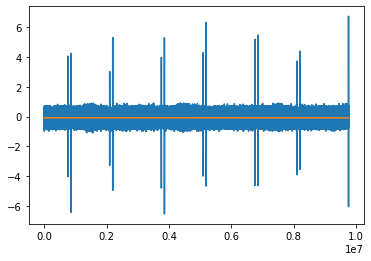

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
from scipy.optimize import minimize,leastsq, curve_fit


def gauss(x):
    return np.exp( -0.5 * x**2 / np.sqrt( 2 * np.pi ) )


def Phi(x):
    return ( 0.5 * ( 1. + erf(x/np.sqrt(2) ) ) )


def skewed(x, x0, s, a):
    return 2./s * gauss( ( x - x0 ) / s ) * Phi( a * ( x - x0 ) / s)


def my_double_peak(x, A0, x0, s0, a, A1, x1, s1):
    return A0 * skewed( x, x0, s0, a ) + A1 / s1 * gauss( ( x - x1 ) / s1 )

data = np.loadtxt("5.csv", skiprows=1, delimiter=',')
xData = range(len(data))

fitResult, ier = curve_fit( my_double_peak, xData, data[:,1], p0=(45e3, 400., 60,4. ,15e3, 700., 30 )  ) 

bestFit = [my_double_peak(x, *fitResult ) for x in range(len(data)) ]


fig1=plt.figure(1)
ax= fig1.add_subplot( 1, 1, 1 )
ax.plot( data[:,1] )
ax.plot( bestFit )

plt.show()